# Accessing the pulse implementation of native gates
All gates are implemented with a sequence of pulses that is carefully calibrated by quantum hardware providers. In this notebook, we will show how to:
- Retrieve the calibrations for any particular native gate of interest, 
- Modify it 
- Submit a circuit where we will overwrite the provider's calibrations and use our modified ones.

These calibrations are vended as PulseSequence objects and contain a list of low-level instructions that are executed for that gate. Obtaining the accurate sequences that are used by the provider offers many advantages. First, it is one of the best ways to understand how quantum computers work at the most fundamental level. It also allows you to improve the results of your circuits by deploying error mitigation techniques such as zero noise extrapolation, by stretching all the pulses of specific gates. 

Native gate calibrations are only available on a subset of devices that have pulse support on Braket.

First, we will start by initializing a cost tracker and import some libraries.

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

In [2]:
%matplotlib inline

from braket.aws import AwsDevice
from braket.native_gates import GateCalibrations
from braket.parametric import FreeParameter
from braket.circuits import Circuit, QubitSet
from braket.circuits.gates import Rx, XY
from braket.circuits.serialization import IRType

import math
from utils.draw_pulse_sequence import draw
import matplotlib.pyplot as plt

Calibrations are associated with a device so we will need to instantiate an AWS device.

In [3]:
device = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3")

Calibrations are accessible via the `gate_calibrations` property of the device object. The calibrations are downloaded and cached when the property is first referenced. In case the device does not support this feature, the `gate_calibrations` property returns `None`.

In [4]:
calibrations = device.gate_calibrations
print(f"The number of pulse implementations in the calibration file is {len(calibrations)}.")

The number of pulse implementations in the calibration file is 925.


To refresh the calibration cache, you can run the following method

In [5]:
calibrations = device.refresh_gate_calibrations()

Retrieving a gate in particular can be done by passing the `Gate` object (instantiating with a numerical value or a `FreeParameter` if necessary) and the qubit of interest to `get_pulse_sequence`. A list of parameters can be obtained via the `parameters` attribute. These parameters can be assigned by passing values when calling the pulse sequence.

In [6]:
xy_theta = XY(FreeParameter("theta"))
rx_pi_2 = Rx(math.pi/2)

a=10
b=113
pulse_sequence_xy_theta_q10_q113 = calibrations.get_pulse_sequence((xy_theta, QubitSet([a, b])))

print("The XY pulse sequence is parametrized by the following parameter(s):", pulse_sequence_xy_theta_q10_q113.parameters)
pulse_sequence_xy_theta_q10_q113_theta0 = pulse_sequence_xy_theta_q10_q113(theta=0)

The XY pulse sequence is parametrized by the following parameter(s): {theta}


You can inspect a calibration by printing it as a OpenPulse program via the `to_ir` function

In [7]:
print(pulse_sequence_xy_theta_q10_q113.to_ir())

OPENQASM 3.0;
cal {
    waveform q10_q113_xy_sqrtiSWAP = {0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00014531289075480011 + 0.00013700508513112716im, 5.341689031575419e-05 - 0.0008196440394224796im, -0.0023318834753716165 + 0.001685333651229498im, 0.008330787766035304 + 0.002163386933588414im, -0.009336602983182403 - 0.01999657585494562im, -0.020890326565835098 + 0.04402276441204698im, 0.09038247585176476 - 0.022869839408293357im, -0.12574632797180543 - 0.09208150889682964im, 0.013533319996194292 + 0.22974724767230012im, 0.22280593769036686 - 0.20745620677932036im, -0.36395518160728607 - 0.047640871744686134im, 0.21887568459174372 + 0.3485363678848143im, 0.13749743439959422 - 0.4160926306604985im, -0.42083104500369195 + 0.16407181883102945im, 0.39961841194278386 + 0.22255906769587258im, -0.08350297085831751 - 0.45181807464005996im, -0.2953920983141557 + 0.35274280718499684im, 0.4602407535979618 + 0.002872650027999397im, -0.2910876044094792 - 0.35655173483982433im, -0.08929554131500311 +

As you have access to a `PulseSequence` object, you can generate the time trace of this pulse sequence via the `to_time_trace` and visualize it with a plotting library like `matplotlib`. We use here a `draw` method that has been placed in a local python file. In the cell below, we draw the pulse sequence for the RX($\pi$/2) gate applied on a qubit 0.

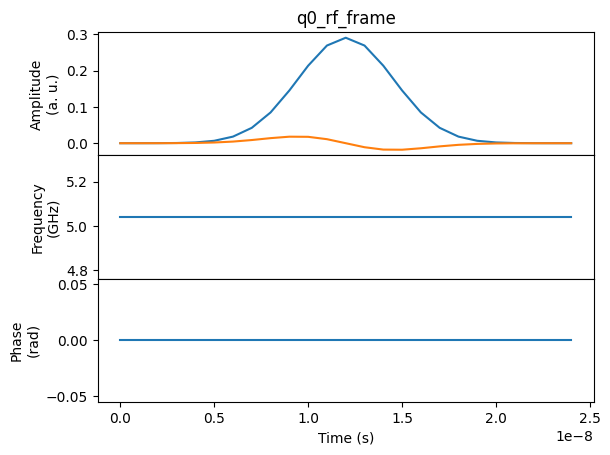

In [8]:
pulse_sequence_rx_pi_2_q0 = calibrations.get_pulse_sequence((rx_pi_2, QubitSet(0)))
draw(pulse_sequence_rx_pi_2_q0)

The fidelity of each gate is reported by Rigetti. It can be retrieved through the Braket console or programmatically through the device properties:

In [9]:
# method 1
print(f"fidelity of the XY gate between qubits {a} and {b}: ", device.properties.provider.specs["2Q"][f"{a}-{b}"]["fXY"])

# method 2
print(f"fidelity of the XY gate between qubits {a} and {b}: ", calibrations.get_fidelity((xy_theta, QubitSet([10, 113]))))

fidelity of the XY gate between qubits 10 and 113:  0.8479629110515803
fidelity of the XY gate between qubits 10 and 113:  0.8479629110515803


# Attaching calibrations to redefine gates

When submitting a circuit to Rigetti's Aspen M-3 via Braket, all the gates of your circuit will be compiled into native gates, which are ultimately replaced by these sequences of pulses. Let's consider a short example that creates the state $\frac{|00\rangle + |11\rangle}{\sqrt{2}}$. 

In [10]:
bell_circuit = (
    Circuit()
    .rx(0,math.pi/2)
    .rx(1,math.pi/2)
    .cz(0,1)
    .rx(1,-math.pi/2)
)
print(bell_circuit)

T  : |   0    |1|    2    |
                           
q0 : -Rx(1.57)-C-----------
               |           
q1 : -Rx(1.57)-Z-Rx(-1.57)-

T  : |   0    |1|    2    |


This circuit is executed via the `run` method.  You are not required to specify any calibration to use the provider's calibrations: pulse scheduling will be done on the hardware provider side with default calibrations.

Text(0, 0.5, 'Population')

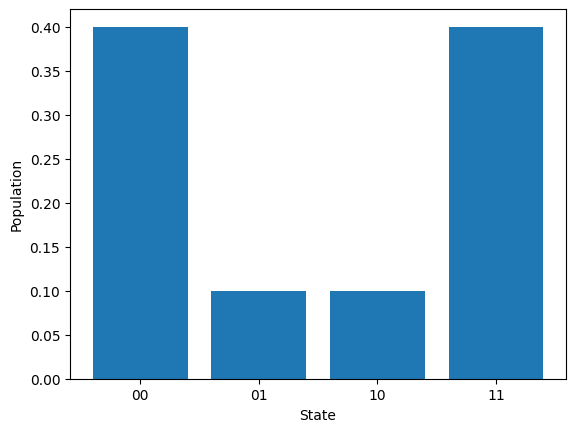

In [11]:
nb_shots = 50
task=device.run(bell_circuit, shots=nb_shots, disable_qubit_rewiring=True)

counts = task.result().measurement_counts
plt.bar(sorted(counts), [counts[k]/nb_shots for k in sorted(counts)])
plt.xlabel("State")
plt.ylabel("Population")

However, you can attach custom-made `PulseSequence`s as calibrations to modify this default behavior. Here we chose to submit one calibration that we have downloaded in one of the first cell of this notebook. You can execute again the same circuit and plot the result histogram.

Text(0, 0.5, 'Population')

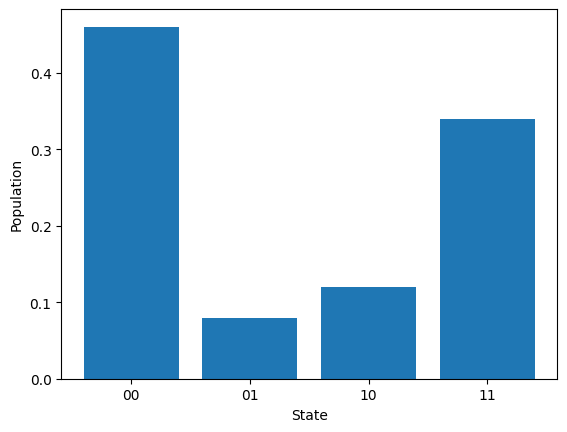

In [12]:
custom_calibration = GateCalibrations({(Rx(math.pi/2), QubitSet(0)): pulse_sequence_rx_pi_2_q0})
task=device.run(bell_circuit, gate_calibrations=custom_calibration, shots=nb_shots, disable_qubit_rewiring=True)

counts = task.result().measurement_counts
plt.bar(sorted(counts), [counts[k]/nb_shots for k in sorted(counts)])
plt.xlabel("State")
plt.ylabel("Population")

You can inspect the OpenPulse program to it is submitted by the previous cell with the `to_ir` function call on the `Circuit` objet using the custom calibration set. You can notice that a calibration definition block is now added to the program and provide the gate definition that will be used when the RX($\pi$/2) gate is applied to qubit 0.

In [13]:
print(bell_circuit.to_ir(IRType.OPENQASM, gate_calibrations=custom_calibration).source)

OPENQASM 3.0;
bit[2] b;
qubit[2] q;
cal {
    waveform wf_drag_gaussian_1 = drag_gaussian(24.000000000000004ns, 2.5479654008640575ns, 2.6743080545793256e-10, 0.290233498642298, false);
}
defcal rx(1.5707963267948966) $0 {
    barrier $0;
    shift_frequency(q0_rf_frame, -321047.14178613486);
    play(q0_rf_frame, wf_drag_gaussian_1);
    shift_frequency(q0_rf_frame, 321047.14178613486);
    barrier $0;
}
rx(1.5707963267948966) q[0];
rx(1.5707963267948966) q[1];
cz q[0], q[1];
rx(-1.5707963267948966) q[1];
b[0] = measure q[0];
b[1] = measure q[1];


In [14]:
print("Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.3f} USD")

Task Summary
{'arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3': {'shots': 100, 'tasks': {'COMPLETED': 2}}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 0.635 USD
